In [67]:
import boto3, subprocess
import datetime
import time
import pandas as pd
import numpy as np
import fabric
from fabric.api import run, hide

In [99]:
class benchmark:
    def __init__(self, experiments, instance_type, image_id="ami-a3b3d4b5", key_name='dpcld_test1', spot=False):
        self.experiments = experiments
        self.instance_type = instance_type
        self.image_id = image_id
        self.key_name = key_name
        self.run_date = datetime.date.strftime(datetime.date.today(), '%Y%m%d')
        self.client = boto3.client('ec2')
        self.ec2 = boto3.resource('ec2')
        self.p_ids = []      
        self.instances = [self.ec2.Instance(_) for _ in ['i-0fde2bafd10b34722']]
        self.spot = spot
        #self.instances = self.setUpInstances()
        
        #self.configureInstances()
        
    def setUpInstances(self):
        num_inst = len(experiments)

        response = self.client.run_instances(ImageId=self.image_id,
                                    InstanceType=self.instance_type,
                                    MinCount=num_inst,
                                    MaxCount=num_inst,
                                    KeyName=self.key_name,
                                    IamInstanceProfile={
                                        'Arn':'arn:aws:iam::465729247037:instance-profile/S3_Admin_Access'}
                                    )

        assert response.get('ResponseMetadata').get('HTTPStatusCode') == 200, "Request ended with an error (HTTPStatusCode != 200)"
        assert len(response.get('Instances')) == num_inst, "Number of instances launched is equal to specified"
        
        instance_ids = []
        instance_ids.extend([_.get('InstanceId') for _ in response.get('Instances')])
              
        waiter = self.client.get_waiter('instance_status_ok')
        waiter.wait(InstanceIds=instance_ids)
        
        print('Set up instances: {}'.format(' '.join(instance_ids)))
        
        self.instances = [self.ec2.Instance(_) for _ in instance_ids]
        
        #return [self.ec2.Instance(_) for _ in instance_ids]
    
    def configureInstances(self):
        [self.configureInstance(i, e) for i, e in zip(self.instances, self.experiments)]
    
    def configureInstance(self, instance, experiment):
        instance.create_tags(Tags=[{'Key':'Name', 'Value':'{}_{} experiment'.format(*experiment)}])
        fabric.api.env.host_string = 'ec2-user@{}'.format(instance.public_dns_name)
        fabric.api.env.key_filename = '~/.ssh/{}.pem'.format(self.key_name)
        fabric.api.env.disable_known_hosts
        fabric.api.hide('output')
        fabric.operations.put('~/Studia/mgr/deepcloud/tests/test_{}_{}.py'.format(*experiment), '.')
        run('sudo pip3 install git+git://github.com/fchollet/keras.git --upgrade')
        run('sudo pip3 install pydot')
        run('sudo pip3 install graphviz')
        
    def runExperiments(self):
        [self.runExperiment(i, e) for i, e in zip(self.instances, self.experiments)]
        
    def runExperiment(self, instance, experiment):
        fabric.api.env.host_string = 'ec2-user@{}'.format(instance.public_dns_name)
        run('mkdir -p logs')
        run('nohup python3 -u test_{0}_{1}.py \
        --run_date {2} --dataset {0} --architecture {1} --instance_type {3} \
        >logs/{2}_{0}_{1}_{3}.log 2>logs/{2}_{0}_{1}_{3}.err < /dev/null &'
            .format(*experiment, self.run_date, self.instance_type), pty=False)
        self.p_ids.append((instance.id, run('pgrep -f "python3 -u test"')))

    def getExperimentLogs(self):
        running_instances = self.instances
        
        while running_instances:
            for instance in self.instances:
                fabric.api.env.host_string = 'ec2-user@{}'.format(instance.public_dns_name)
                
                status = benchmark_td1.client.describe_instance_status(InstanceIds=[instance.id])\
                .get('InstanceStatuses')[0]\
                .get('InstanceState')\
                .get('Name')

                if status != 'running':
                    print('Instance {} not running'.format(instance.id))
                    running_instances.remove(instance)
                    continue
                    
                self.rSync(instance.public_dns_name)
                self.syncWithS3()
                
                try:
                    run('pgrep -f "python3 -u test"')
                except:
                    print('Process on instance {} not found'.format(instance.id))
                    running_instances.remove(instance)
                    continue
                    
                time.sleep(1)
                
            print('{}: synchronized logs from all instances'.format(datetime.datetime.now().isoformat()))
        else:
            print('All instances are down or finished their tasks')

    def rSync(self, public_dns):
        fabric.operations.local('rsync -aL -e "ssh -i ~/.ssh/{}.pem -o StrictHostKeyChecking=no" \
        --include="/home/ec2-user/logs/*" --include="*.log" --include="*.err" \
        --include="*.out" --include="*.png" --exclude="*" \
        ec2-user@{}:/home/ec2-user/logs/ \
        ~/Studia/mgr/deepcloud/tests/logs/'\
                                .format(self.key_name, public_dns))
        
    def syncWithS3(self):
        run('aws s3 sync /home/ec2-user/logs s3://deepcloud-logs/ --exclude="*"\
        --include="*.log" --include="*.err" \
        --include="*.out" --include="*.png" --region "us-east-2"')


In [167]:
'''        
        if self.spot:
            response = self.client.request_spot_instances(
                SpotPrice = str(checkSpotPrices().percentile(0.99)*1.1),
                InstanceCount = num_inst,
                
                
                LaunchSpecification = {'ImageId':self.image_id,
                                      'InstanceType':self.instance_type,
                                      'KeyName':self.key_name,
                                      'IamInstanceProfile':{
                                        'Arn':'arn:aws:iam::465729247037:instance-profile/S3_Admin_Access'}
                                      })
            waiter = self.waiter.SpotInstanceRequestFulfilled(SpotInstanceRequestIds=[response.get('SpotInstanceRequests')[0].get('SpotInstanceRequestId')])
            
            client.describe_spot_instance_requests(SpotInstanceRequestIds=[response.get('SpotInstanceRequests')[0].get('SpotInstanceRequestId')])
        
        else:
        
                
    def checkSpotPrices(self):
        spotprices = client.describe_spot_price_history(InstanceTypes=['p2.xlarge'],
                                            StartTime=datetime.datetime.today()-datetime.timedelta(1),
                                            EndTime=datetime.datetime.today()
                                           )['SpotPriceHistory']
        prices = pd.Series([x.get('SpotPrice') for x in spotprices]).astype(float)
        return prices
        

'''

In [166]:
spotprices = client.describe_spot_price_history(InstanceTypes=['p2.xlarge'],
                                    StartTime=datetime.datetime.today()-datetime.timedelta(1),
                                    EndTime=datetime.datetime.today()
                                   )['SpotPriceHistory']
prices = pd.Series([x.get('SpotPrice') for x in spotprices]).astype(float)
prices.quantile(0.99)        

0.3638

In [106]:
experiments = [("mnist","kerasdef")]

In [107]:
benchmark_td1 = benchmark(experiments=experiments,instance_type='t2.micro')

In [108]:
#benchmark_td1.setUpInstances()

In [109]:
#benchmark_td1.configureInstances()

In [112]:
benchmark_td1.runExperiments()

[ec2-user@ec2-52-205-101-77.compute-1.amazonaws.com] run: mkdir -p logs
[ec2-user@ec2-52-205-101-77.compute-1.amazonaws.com] run: nohup python3 -u test_mnist_kerasdef.py         --run_date 20170530 --dataset mnist --architecture kerasdef --instance_type t2.micro         >logs/20170530_mnist_kerasdef_t2.micro.log 2>logs/20170530_mnist_kerasdef_t2.micro.err < /dev/null &
[ec2-user@ec2-52-205-101-77.compute-1.amazonaws.com] run: pgrep -f "python3 -u test"
[ec2-user@ec2-52-205-101-77.compute-1.amazonaws.com] out: 14339
[ec2-user@ec2-52-205-101-77.compute-1.amazonaws.com] out: 



In [96]:
benchmark_td1.getExperimentLogs()

[localhost] local: rsync -aL -e "ssh -i ~/.ssh/dpcld_test1.pem -o StrictHostKeyChecking=no"         --include="/home/ec2-user/logs/*" --include="*.log" --include="*.err"         --include="*.out" --include="*.png" --exclude="*"         ec2-user@ec2-52-205-101-77.compute-1.amazonaws.com:/home/ec2-user/logs/         ~/Studia/mgr/deepcloud/tests/logs/
[ec2-user@ec2-52-205-101-77.compute-1.amazonaws.com] run: aws s3 sync /home/ec2-user/logs s3://deepcloud-logs/ --exclude="*"        --include="*.log" --include="*.err"         --include="*.out" --include="*.png" --region "us-east-2"
[ec2-user@ec2-52-205-101-77.compute-1.amazonaws.com] out: Completed 548 Bytes/548 Bytes (10.7 KiB/s) with 2 file(s) remaining
[ec2-user@ec2-52-205-101-77.compute-1.amazonaws.com] out: upload: logs/20170530_mnist_kerasdef_t2.micro.err to s3://deepcloud-logs/20170530_mnist_kerasdef_t2.micro.err
[ec2-user@ec2-52-205-101-77.compute-1.amazonaws.com] out: Completed 548 Bytes/548 Bytes (10.7 KiB/s) with 1 file(s) remain

In [114]:
term_responses = [_.terminate() for _ in benchmark_td1.instances]

In [113]:
benchmark_td1.instances

[ec2.Instance(id='i-0fde2bafd10b34722')]

In [ ]:
image_id="ami-a3b3d4b5"
key_name='dpcld_test1'

In [120]:
import matplotlib
client = boto3.client('ec2')
ec2 = boto3.resource('ec2')

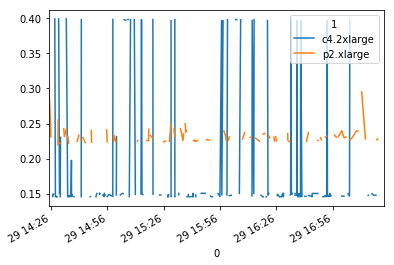

In [146]:
# rynek spot

spotprices = client.describe_spot_price_history(InstanceTypes=['c4.2xlarge','p2.xlarge'],
                                                StartTime=datetime.datetime.today()-datetime.timedelta(2),
                                                EndTime=datetime.datetime.today()-datetime.timedelta(1)
                                               )['SpotPriceHistory']
prices = pd.DataFrame.from_records([(x.get('Timestamp'),x.get('InstanceType'),x.get('SpotPrice')) for x in spotprices])
prices[2] = prices[2].astype(float)
prices[4] = prices[0].apply(lambda x: x.date())
prices.pivot_table(index=4, columns=1, values=2, aggfunc='median')
%matplotlib inline
prices.pivot_table(index=0, columns=1, values=2, aggfunc='mean').plot()
spot_specs = {"ImageID":"ami-4191b524",
             "InstanceType":"t2.micro",
             "Placement":{"AvailabilityZone":"us-east-2"}}


In [152]:
prices[prices[1] == 'p2.xlarge'][2].quantile(0.99)

0.304708

In [148]:
print(prices[prices[1] == 'p2.xlarge'].quantile(0.99))
print(prices[prices[1] == 'c4.2xlarge'].quantile(0.95))

2    0.304708
Name: 0.99, dtype: float64
2    0.398
Name: 0.95, dtype: float64


In [ ]:
len(response.get('Instances'))

In [ ]:
response.get('HTTPStatusCode')

In [ ]:
#key pair
response = client.run_instances(ImageId=image_id,
                                InstanceType=instance_type,
                                MinCount=num_inst,
                                MaxCount=num_inst,
                                KeyName=key_name
                               )
#_instanceId=response.get('Instances')[0].get('InstanceId')

In [ ]:
instance_ids = []
instance_ids.extend([_.get('InstanceId') for _ in response.get('Instances')])

In [ ]:
instances = [ec2.Instance(_) for _ in instance_ids]

In [ ]:
waiter = client.get_waiter('instance_status_ok')
waiter.wait(InstanceIds=instance_ids)

In [ ]:
p_ids = []
def configureInstance(instance, p_ids=p_ids):
    env.host_string = 'ec2-user@{}'.format(instance.public_dns_name)
    env.key_filename = '~/.ssh/dpcld_test1.pem'.format(key_name)
    env.disable_known_hosts
    fabric.operations.put('~/Studia/mgr/deepcloud/tests/test_mnist.py', '.')
    run('sudo pip3 install git+git://github.com/fchollet/keras.git --upgrade')
    run('sudo pip3 install pydot')
    run('sudo pip3 install graphviz')
    run('nohup python3 -u test_mnist.py >test_mnist.log 2>test_mnist.err < /dev/null &', pty=False)
    p_ids.append({instance.id:run('pgrep -f "python3 -u test"')})

In [ ]:
configureInstance(instances[0])

In [ ]:
term_responses = [_.terminate() for _ in instances]

In [ ]:
term_responses